In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid', {'axes.grid': False})

In [2]:
originals_dir = 'originals'
data_dir = 'data'
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

classes = ['DUM555', 'DUM560', 'DUM562', 'DUM587', 'DUM588']

```py
# to remove the info bar
for c in classes:
    c_names = os.listdir(os.path.join(originals_dir, c))
    c_names = [x for x in c_names if x.endswith('.tif')]
    print('{} imgs for class {} found'.format(len(c_names), c))
    for i in c_names:
        img = cv2.imread(os.path.join(originals_dir, c, i))
        if img.shape == (1886, 2048, 3):
            img = img[:1886-118, :]
        elif img.shape == (1024, 1280, 3):
            img = img[:1024-64, :]
        else:
            raise Exception('Image of unsupported shape.')
        cv2.imwrite(os.path.join(data_dir, c, i), img)
```

### Same / similar images

DUM555_016.tif and DUM555_017.tif

DUM560_021.tif and DUM560_022.tif

DUM562_002.tif and DUM562_003.tif?

DUM562_009.tif and DUM562_010.tif?

DUM562_011.tif and DUM562_012.tif

DUM587_004.tif and DUM587_005.tif

DUM587_009.tif and DUM587.010.tif

DUM587_012.tif and DUM587_013.tif

In [3]:
def plot_grayscale_distribution(img):
    fig = plt.figure(figsize=(50,5))
    ax = fig.add_subplot(1, 4, 1)
    bins = list(range(255))
    n, bins, patches = ax.hist(img.flatten(), bins=bins)
    ax.set_xlabel('Grayscale')
    ax.set_ylabel('Count')
    ax.set_title('Histogram of grayscale image')
    fig.tight_layout()
    plt.show()

In [4]:
from scipy.ndimage.filters import median_filter, gaussian_filter

def filters(img, median_filter_size=(9, 9, 1), gaussian_sigma=4):
    
    median_filted = median_filter(img, size=median_filter_size)
    gaussian_filted = gaussian_filter(median_filted, sigma=gaussian_sigma)
    return cv2.cvtColor(gaussian_filted, cv2.COLOR_BGR2GRAY)

In [5]:
from sklearn import cluster

def segmentation(img):
    kmeans = cluster.KMeans(n_clusters=3)
    kmeans.fit(img.flatten().reshape(-1, 1))
    labels = kmeans.labels_.reshape(img.shape)
    
    seg_img = np.zeros((img.shape[0], img.shape[1], 3)).astype('float')
    # colors = sns.color_palette('hls', 3)
    colors = sns.color_palette(['#DB5E56', '#56DB7F', '#566FDB'])
    # colors = [sns.xkcd_rgb["coral"], sns.xkcd_rgb["apple"], sns.xkcd_rgb["neon blue"]]
    for c in range(3):
        segc = (labels == c)
        seg_img[:,:,0] += (segc*(colors[c][0]))
        seg_img[:,:,1] += (segc*(colors[c][1]))
        seg_img[:,:,2] += (segc*(colors[c][2]))
    return seg_img

## Test Segmentation

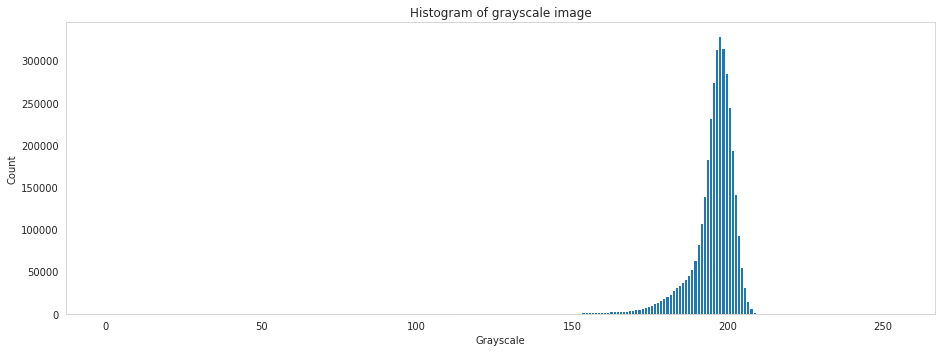

In [6]:
test_img_name = "DUM562/DUM562_011.tif"
test_img= cv2.imread(os.path.join(os.path.join(data_dir, test_img_name)))
filtered_img = filters(test_img, median_filter_size=(9, 9, 1), gaussian_sigma=5)
segmented_img = segmentation(filtered_img)

plot_grayscale_distribution(filtered_img)

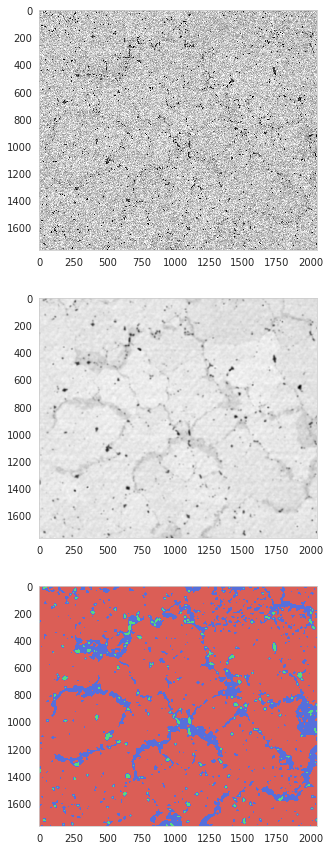

In [7]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(3, 1, 1)
plt.imshow(test_img)
ax = fig.add_subplot(3, 1, 2)
plt.imshow(filtered_img, 'gray')
ax = fig.add_subplot(3, 1, 3)
plt.imshow(segmented_img)

## Test Classification

In [8]:
from sklearn import cluster

def extract_feature(img):
    kmeans = cluster.KMeans(n_clusters=3)
    kmeans.fit(img.flatten().reshape(-1, 1))
    l = kmeans.labels_.reshape(img.shape)
    f = [(l==0).sum(), (l==1).sum(), (l==2).sum()]
    # print(f)
    avg = []
    for c in range(3):
        segc = (l == c)
        count = (l==c).sum()
        avg.append((segc*img[:,:]).sum() / count)
    # print(avg)
    return np.asarray([x for x, _ in sorted(zip(f, avg), key=lambda pair:pair[1], reverse=True)])

In [9]:
def get_x():
    features = []
    print('Extracting features ...')
    for c in classes:
        count = 0
        for img_name in sorted(os.listdir(os.path.join(data_dir, c))):
            count += 1
            if not img_name.endswith('.tif'):
                continue
            img = cv2.imread(os.path.join(data_dir, c, img_name))
            filtered_img = filters(img)
            f = extract_feature(filtered_img)
            f = np.expand_dims(f, 0)
            if len(features) == 0:
                features = f
            else:
                features = np.vstack((features, f))
        print('  extracted features from {} imgs of class {}'.format(count, c))
    return features

In [10]:
def get_y():
    Y = []
    for idx, c in enumerate(classes):
        imgs = os.listdir(os.path.join(data_dir, c))
        imgs = [i for i in imgs if i.endswith('.tif')]
        Y += [idx] * len (imgs)
    return np.asarray(Y)

In [13]:
def get_xny():
    X = get_x()
    Y = get_y()
    print('x -', X.shape)
    print('y -', Y.shape)
    return X, Y

In [14]:
X, Y = get_xny()
print('Data:')
for idx, c in enumerate(classes):
    print('  {} imgs of class {}'.format(np.count_nonzero(Y==idx), c))

Extracting features ...
  extracted features from 16 imgs of class DUM555
  extracted features from 33 imgs of class DUM560
  extracted features from 21 imgs of class DUM562
  extracted features from 43 imgs of class DUM587
  extracted features from 27 imgs of class DUM588
x - (140, 3)
y - (140,)
Data:
  16 imgs of class DUM555
  33 imgs of class DUM560
  21 imgs of class DUM562
  43 imgs of class DUM587
  27 imgs of class DUM588


In [15]:
print('Data:')
for idx, c in enumerate(classes):
    print('  {} imgs of class {}'.format(np.count_nonzero(Y==idx), c))

Data:
  16 imgs of class DUM555
  33 imgs of class DUM560
  21 imgs of class DUM562
  43 imgs of class DUM587
  27 imgs of class DUM588


In [40]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

import warnings; warnings.simplefilter('ignore')

skf = StratifiedKFold(n_splits=5)
count = 1
acc = []
for train_index, test_index in skf.split(np.zeros((len(Y), 1)), Y):
    print('k-fold: #{}'.format(count))
    count += 1
    train_labels = Y[train_index]
    test_labels = Y[test_index]
    train = X[train_index]
    test = X[test_index]
    model = RandomForestClassifier(n_estimators=100,
                                   max_features='sqrt',
                                   n_jobs=-1, verbose=0)
    model.fit(train, train_labels)
    n_nodes = []
    max_depths = []

    for ind_tree in model.estimators_:
        n_nodes.append(ind_tree.tree_.node_count)
        max_depths.append(ind_tree.tree_.max_depth)
    
    print(f'    Average number of nodes {int(np.mean(n_nodes))}')
    print(f'    Average maximum depth {int(np.mean(max_depths))}')
    
    train_rf_predictions = model.predict(train)
    train_rf_probs = model.predict_proba(train)[:, 1]
    rf_predictions = model.predict(test)
    rf_probs = model.predict_proba(test)[:, 1]
    
    a = sum((rf_predictions==test_labels)/len(test))
    acc.append(a)
    print('    Model accuracy: {}'.format(a))
    print('    Feature importances: {}'.format(model.feature_importances_))

print('\nAverage accuracy: {}'.format(sum(acc) / len(acc)))

k-fold: #1
    Average number of nodes 39
    Average maximum depth 7
    Model accuracy: 0.8709677419354833
    Feature importances: [0.31104003 0.35081944 0.33814053]
k-fold: #2
    Average number of nodes 43
    Average maximum depth 7
    Model accuracy: 0.8620689655172411
    Feature importances: [0.32723668 0.31957771 0.35318561]
k-fold: #3
    Average number of nodes 41
    Average maximum depth 7
    Model accuracy: 0.7857142857142855
    Feature importances: [0.33411657 0.33367728 0.33220615]
k-fold: #4
    Average number of nodes 40
    Average maximum depth 7
    Model accuracy: 0.7307692307692305
    Feature importances: [0.343794   0.38229273 0.27391327]
k-fold: #5
    Average number of nodes 42
    Average maximum depth 7
    Model accuracy: 0.8076923076923074
    Feature importances: [0.31328724 0.36994319 0.31676957]

Average accuracy: 0.8114425063257095


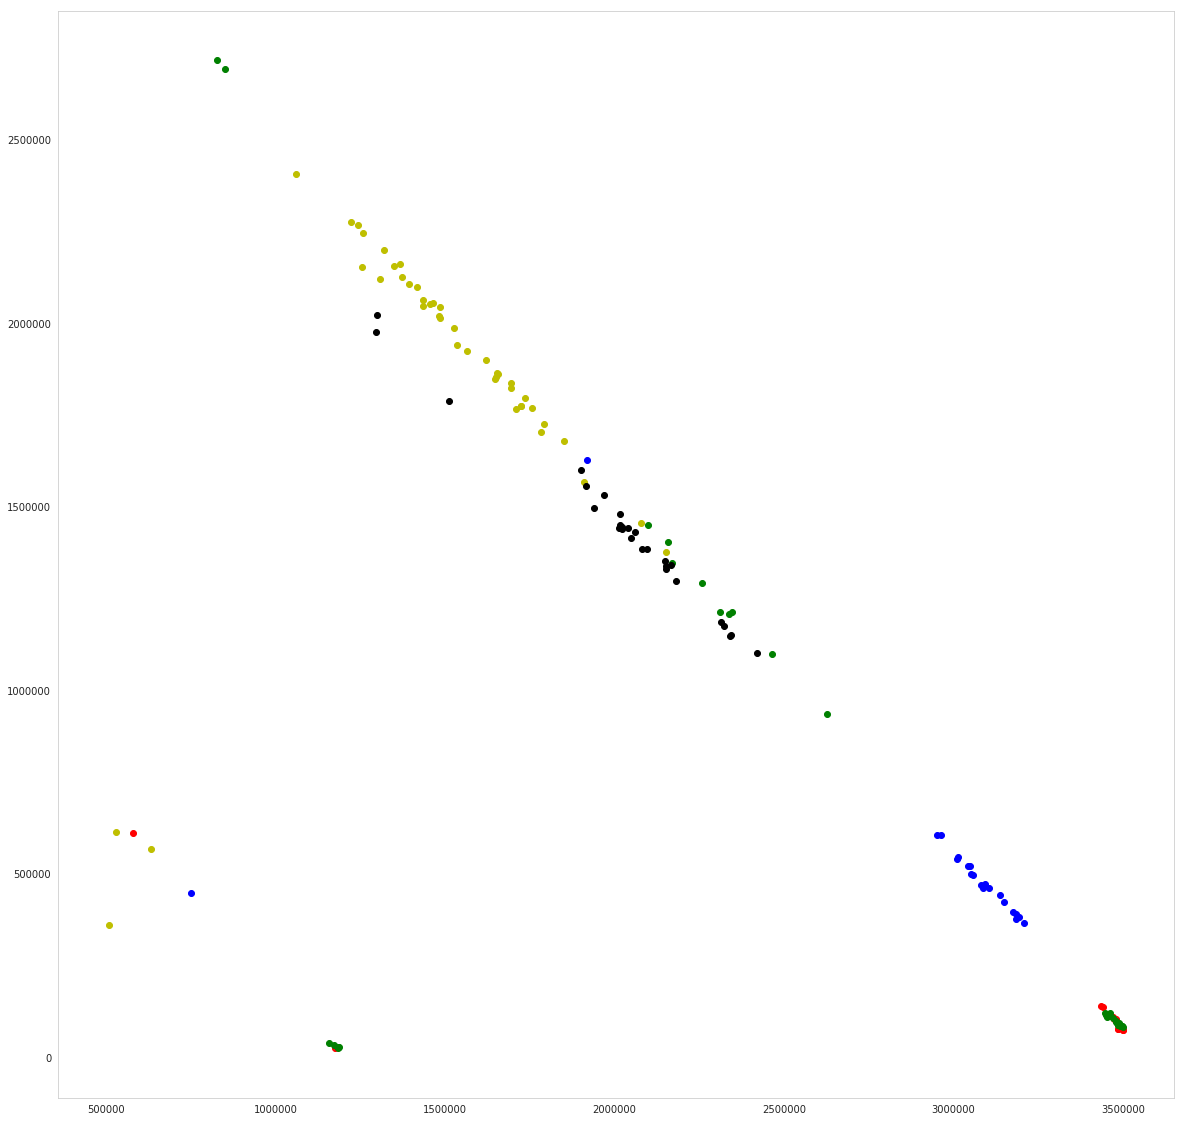

In [53]:
plotx = X[:, :2]
plotx1 = plotx[0:16]
plotx2 = plotx[16:49]
plotx3 = plotx[49:70]
plotx4 = plotx[70:113]
plotx5 = plotx[113:140]

fig = plt.figure(figsize=(20, 20))
plt.plot(plotx1[:, 0], plotx1[:, 1], 'ro')
plt.plot(plotx2[:, 0], plotx2[:, 1], 'go')
plt.plot(plotx3[:, 0], plotx3[:, 1], 'bo')
plt.plot(plotx4[:, 0], plotx4[:, 1], 'yo')
plt.plot(plotx5[:, 0], plotx5[:, 1], 'ko')

plt.savefig('classification.eps', format='eps', dpi=1000)

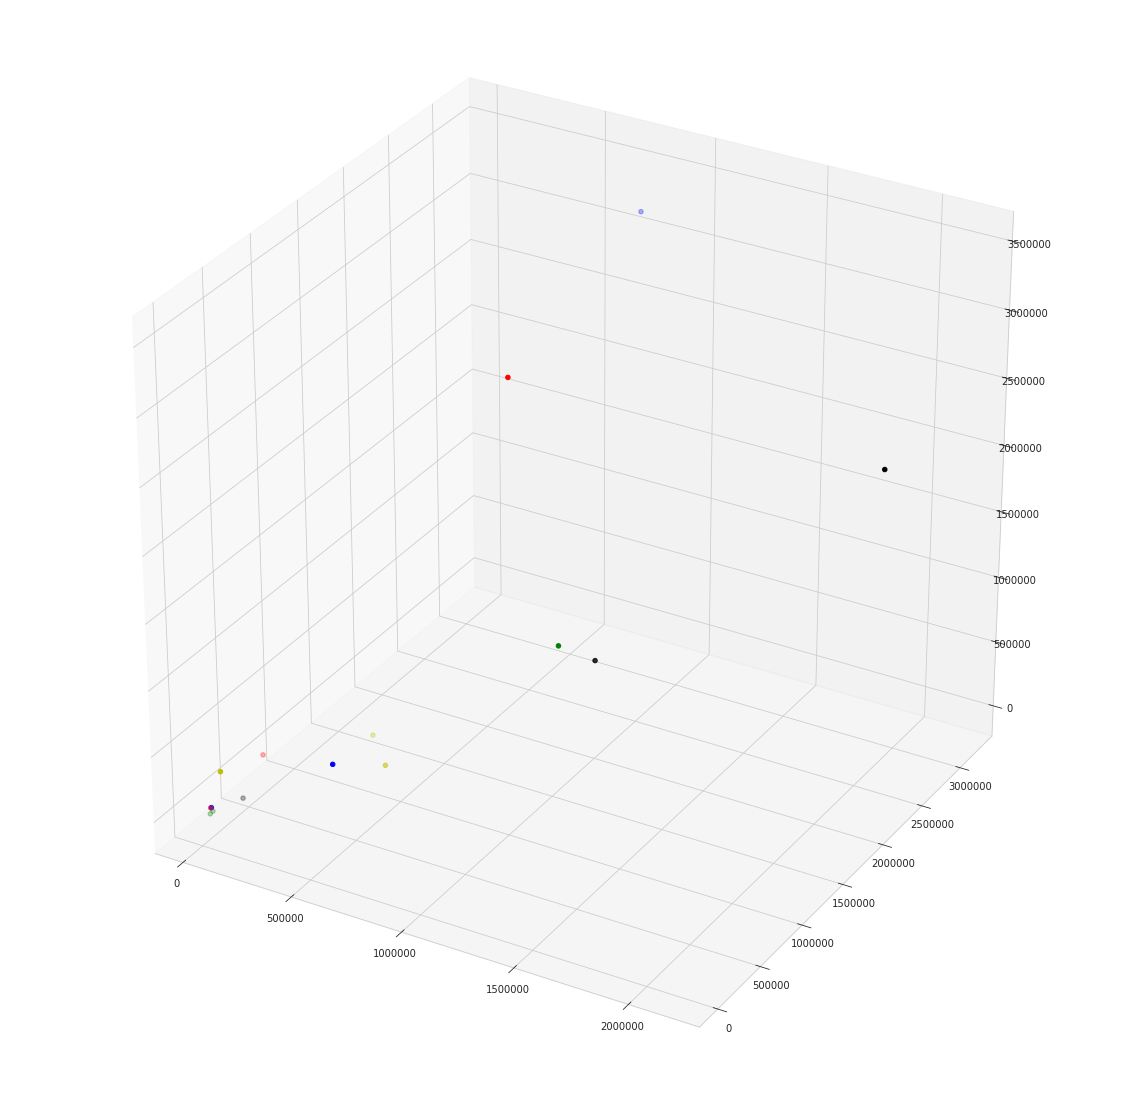

In [67]:
from mpl_toolkits.mplot3d import Axes3D

plotx1 = X[0:16]
plotx2 = X[16:49]
plotx3 = X[49:70]
plotx4 = X[70:113]
plotx5 = X[113:140]

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(plotx1[0], plotx1[1], plotx1[2], c='r', marker='o')
ax.scatter(plotx2[0], plotx2[1], plotx2[2], c='g', marker='o')
ax.scatter(plotx3[0], plotx3[1], plotx3[2], c='b', marker='o')
ax.scatter(plotx4[0], plotx4[1], plotx4[2], c='y', marker='o')
ax.scatter(plotx5[0], plotx5[1], plotx5[2], c='k', marker='o')

fig.savefig('classification3d.eps', format='eps', dpi=1000)

# -------- x --------

In [16]:
from sklearn.model_selection import train_test_split

train, test, train_labels, test_labels = train_test_split(X, Y, stratify=Y, test_size=0.3)

In [17]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100,
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

model.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [18]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 38
Average maximum depth 7


In [19]:
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [20]:
sum(rf_predictions==test_labels)/len(test)

0.8571428571428571

In [21]:
model.feature_importances_

array([0.33772167, 0.33328902, 0.32898932])

In [29]:
from sklearn.model_selection import StratifiedKFold
import features, preprocessing, dimension_reduction, classifiers, regression

import warnings; warnings.simplefilter('ignore')

skf = StratifiedKFold(n_splits=5)
a = []
f = []
p = []
r = []
rr = []
m = []

for train_index, test_index in skf.split(np.zeros((len(Y), 1)), Y):
    train_labels = Y[train_index]
    test_labels = Y[test_index]
    train = X[train_index]
    test = X[test_index]

    train, test, _ = preprocessing.preprocessing(train, test)

    train, test = dimension_reduction.principal_components(train, test)

    acc, f1, prec, rec, conf, probs, pred = classifiers.random_forest(train, train_labels, test, test_labels)
    a.append(acc)
    f.append(f1)
    p.append(prec)
    r.append(rec)
    
    reg_train_labels = np.random.rand(len(train_labels), 1)
    reg_test_labels = np.random.rand(len(test_labels), 1)
    r2, mse = regression.linear_regression(train, test, reg_train_labels, reg_test_labels)
    rr.append(r2)
    m.append(mse)

print('Accuracy:', np.mean(a))
print('F1 - score:', np.mean(f))
print('Precision:', np.mean(p))
print('Recall:', np.mean(r))

print("R2-score:", np.mean(rr))
print("Mean square error:", np.mean(m))

Accuracy: 0.7372556809153027
F1 - score: 0.7129070491394625
Precision: 0.7419822483782439
Recall: 0.7372556809153027
R2-score: -0.08872028990287566
Mean square error: 0.08385952464090832


In [33]:
import glob

haralick = []
# hog = []
lbp = []
# hu = []
# zernike = []
# vgg = []
# inception = []
# Y = []
for i in range(len(classes)):
    names = glob.glob(data_dir + '/' + classes[i] + '/*.tif')
    if i == 0:
        haralick = features.haralick_features(names)
        # hog = features.hog_features(names)
        lbp = features.lbp_features(names)
        # hu = features.hu_moments(names)
        # zernike = features.zernike_moments(names)
        # vgg = features.VGG(names)
        # inception = features.inception(names)
    else:
        haralick = np.vstack((haralick, features.haralick_features(names)))
        # hog = np.vstack((hog, features.hog_features(names)))
        lbp = np.vstack((lbp, features.lbp_features(names)))
        # hu = np.vstack((hu, features.hu_moments(names)))
        # zernike = np.vstack((zernike, features.zernike_moments(names)))
        # vgg = np.vstack((vgg, features.VGG(names)))
        # inception = np.vstack((inception, features.inception(names)))
    # Y += [i] * len(names)
# Y = np.asarray(Y)

In [34]:
allfeatures = np.column_stack((haralick, lbp, X))

In [35]:
from sklearn.model_selection import StratifiedKFold
import features, preprocessing, dimension_reduction, classifiers, regression

import warnings; warnings.simplefilter('ignore')

skf = StratifiedKFold(n_splits=5)
a = []
f = []
p = []
r = []
rr = []
m = []

for train_index, test_index in skf.split(np.zeros((len(Y), 1)), Y):
    train_labels = Y[train_index]
    test_labels = Y[test_index]
    train = allfeatures[train_index]
    test = allfeatures[test_index]

    train, test, _ = preprocessing.preprocessing(train, test)

    train, test = dimension_reduction.principal_components(train, test)

    acc, f1, prec, rec, conf, probs, pred = classifiers.random_forest(train, train_labels, test, test_labels)
    a.append(acc)
    f.append(f1)
    p.append(prec)
    r.append(rec)
    
    reg_train_labels = np.random.rand(len(train_labels), 1)
    reg_test_labels = np.random.rand(len(test_labels), 1)
    r2, mse = regression.linear_regression(train, test, reg_train_labels, reg_test_labels)
    rr.append(r2)
    m.append(mse)

print('Accuracy:', np.mean(a))
print('F1 - score:', np.mean(f))
print('Precision:', np.mean(p))
print('Recall:', np.mean(r))

print("R2-score:", np.mean(rr))
print("Mean square error:", np.mean(m))

Accuracy: 0.9147960493344254
F1 - score: 0.9153973914734237
Precision: 0.9279183066655257
Recall: 0.9147960493344254
R2-score: -0.043017673663079
Mean square error: 0.08660871057810089
